<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_AR_seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
!pip install yfinance

In [94]:
!pip install pmdarima statsmodels scikit-learn

In [95]:
#!pip install --upgrade scikit-learn pmdarima

In [96]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg


# Load Data

In [97]:
df = pd.read_excel('LREN3.BALANCO.xls', sheet_name='Dem. Result.', skiprows=range(0, 1))
#rotacionando a tabela
df = df.T
#settando o cabeçalho com os valores da primeira linha
df.columns = df.iloc[0]
#excluindo a primeira linha
df=df.iloc[1:]
#convertando o formato da data e, posteriormente, atualizando o índice.
df.index = pd.to_datetime(df.index,format='%d/%m/%Y')
df = df.rename(columns={'Resultado Bruto':'y'})
df = df[['y']]
df['y'] = df['y'].astype(float)
#definindo a frequencia do índice
df=df.asfreq('Q-DEC')


WARNING *** file size (90809) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


<ipython-input-97-36c2c8c8433c>:14: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df=df.asfreq('Q-DEC')


In [98]:
df

,y
2008-09-30,268497.984
2008-12-31,335086.976
2009-03-31,227459.008
2009-06-30,321312.992
2009-09-30,289395.008
2009-12-31,413883.936
2010-03-31,278174.016
2010-06-30,396100.000
2010-09-30,344235.008
2010-12-31,523370.016


<Axes: >

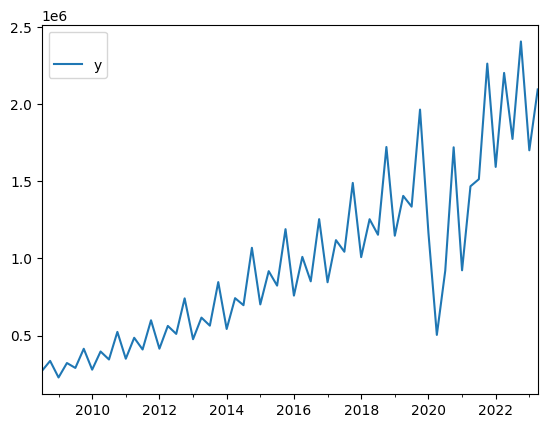

In [99]:
df.plot()

## Train / Test

In [100]:
size = int(len(df) * 0.7)
train, test = df[0:size], df[size:len(df)]
h = len(test)
print(train.shape)
print(test.shape)

(42, 1)
(18, 1)


In [101]:
train

,y
2008-09-30,268497.984
2008-12-31,335086.976
2009-03-31,227459.008
2009-06-30,321312.992
2009-09-30,289395.008
2009-12-31,413883.936
2010-03-31,278174.016
2010-06-30,396100.000
2010-09-30,344235.008
2010-12-31,523370.016


# Analysis

<Axes: >

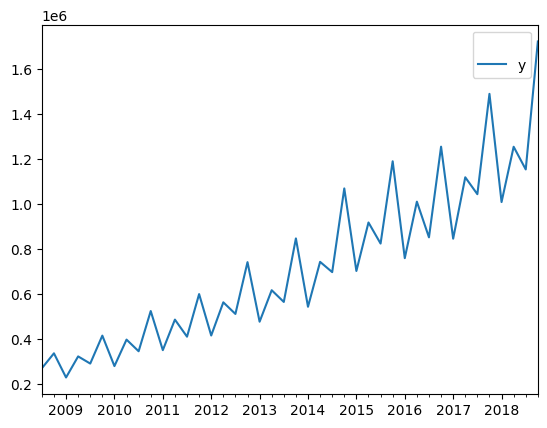

In [102]:
train.plot()

<Axes: ylabel='Density'>

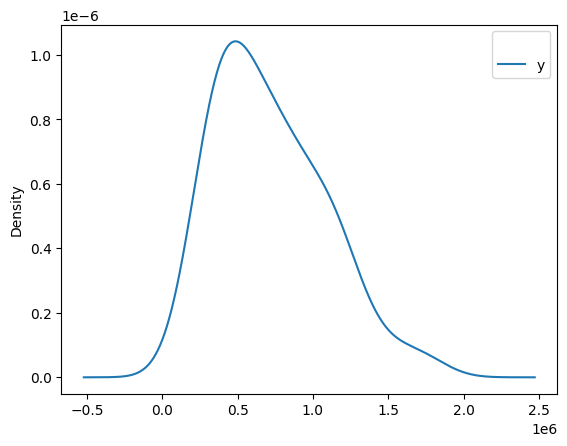

In [103]:
train.plot(kind='kde')

<Axes: >

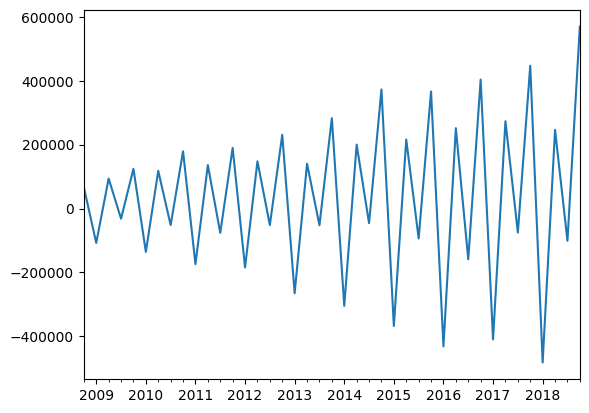

In [104]:
diff1 = train['y'].diff(1).dropna()
diff1.plot()

## Normalization

In [105]:
train_log = train.copy()
train_log['y']=np.log(train_log['y'])

In [106]:
train_log

,y
2008-09-30,12.500599
2008-12-31,12.722145
2009-03-31,12.334725
2009-06-30,12.680171
2009-09-30,12.575548
2009-12-31,12.933341
2010-03-31,12.536002
2010-06-30,12.889422
2010-09-30,12.749080
2010-12-31,13.168044


<Axes: >

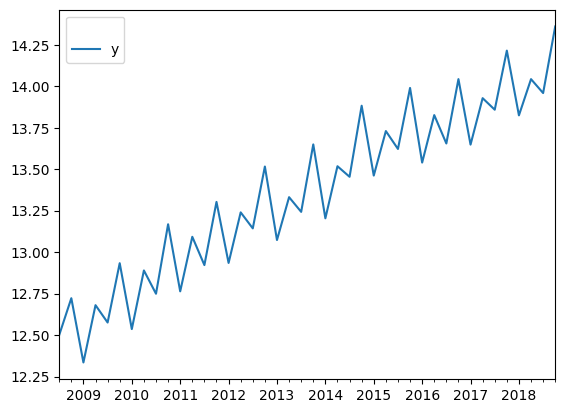

In [107]:
train_log.plot()

<Axes: ylabel='Density'>

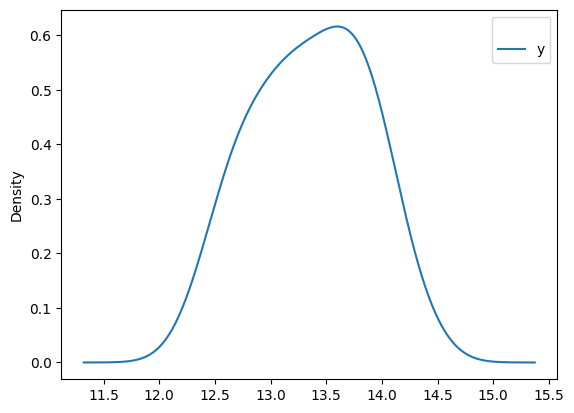

In [108]:
train_log.plot(kind='kde')

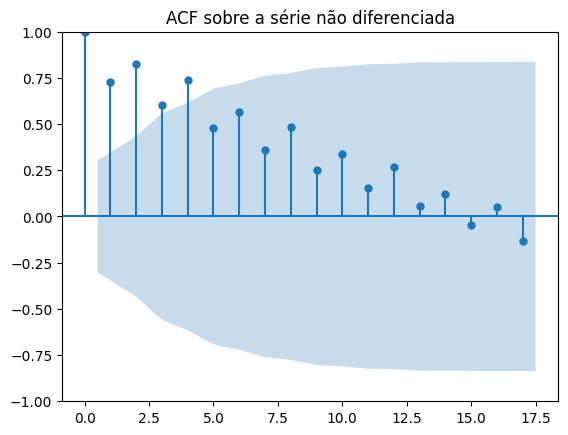

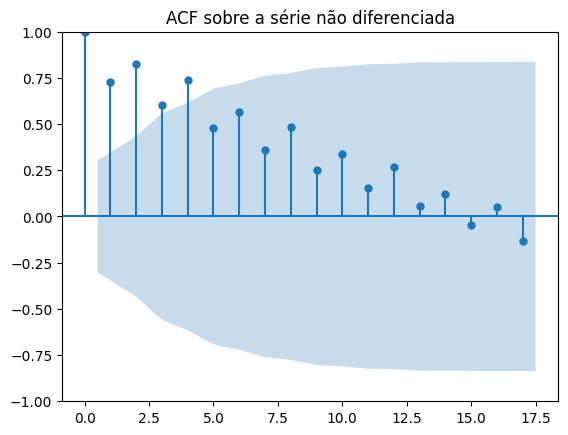

In [109]:
plot_acf(train_log, title='ACF sobre a série não diferenciada')

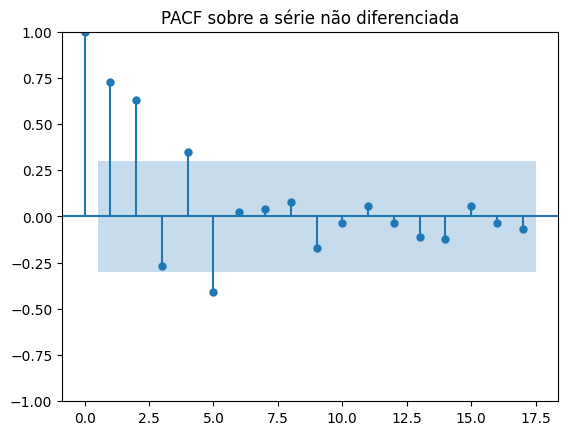

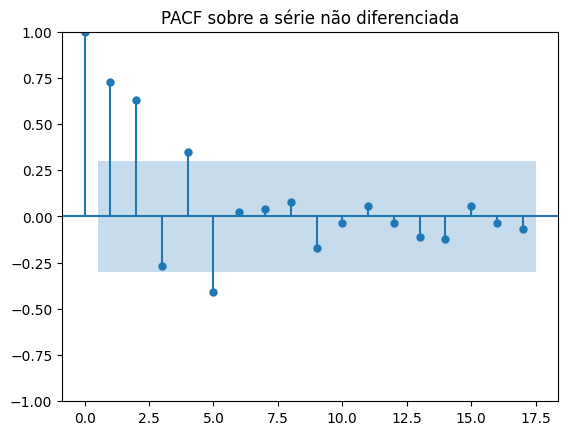

In [110]:
plot_pacf(train_log, title='PACF sobre a série não diferenciada')

In [111]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [112]:
adf_test(train_log)

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.836832
p-value                  0.362335
# lags used              9.000000
# observations          32.000000
critical value (1%)     -3.653520
critical value (5%)     -2.957219
critical value (10%)    -2.617588
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Differentiation

### Seasonal differencing

In [113]:
diff1 = train_log['y'].diff(4).dropna()

In [114]:
diff1.mean()

np.float64(0.15653638634907363)

<Axes: >

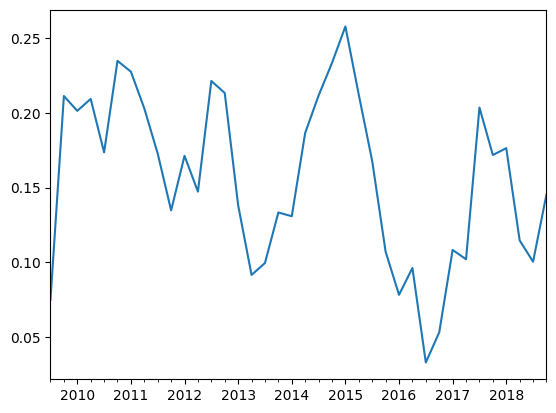

In [115]:
diff1.plot()

<Axes: ylabel='Density'>

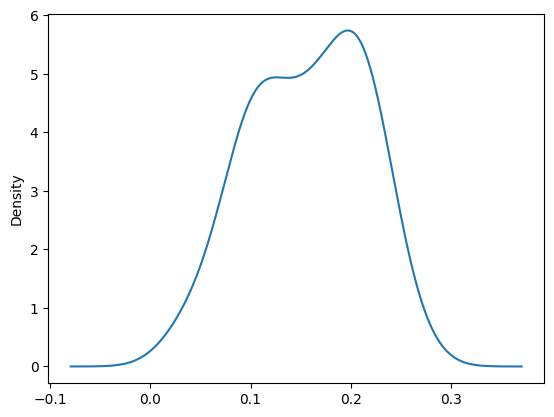

In [116]:
diff1.plot(kind='kde')

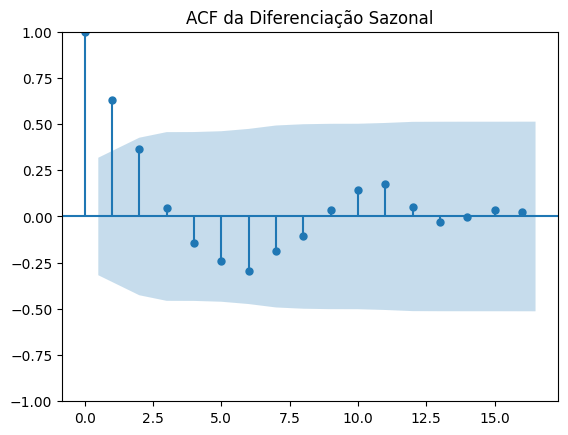

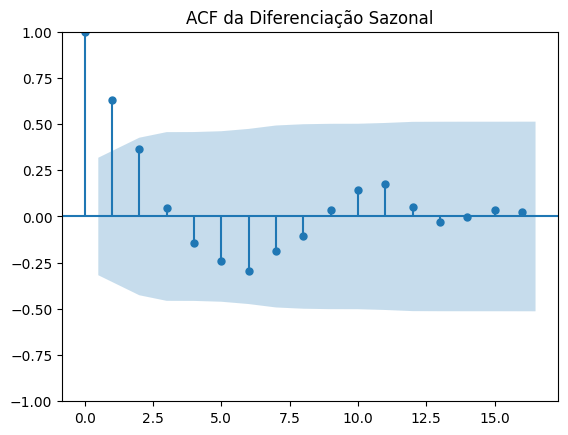

In [117]:
plot_acf(diff1, title='ACF da Diferenciação Sazonal')

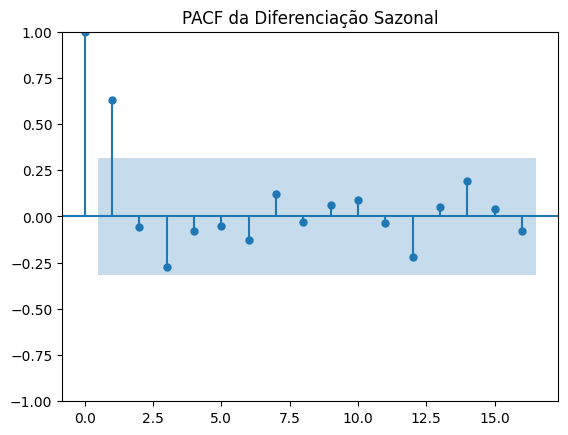

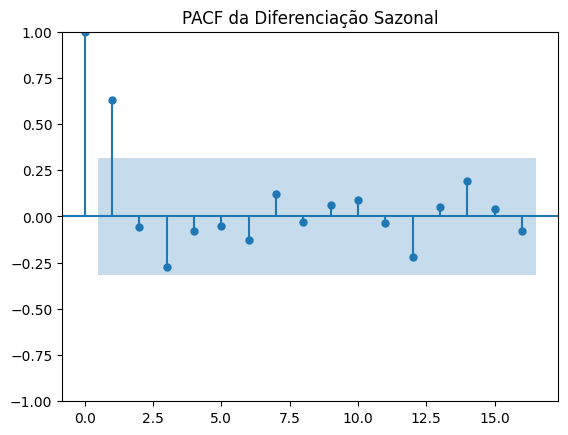

In [118]:
plot_pacf(diff1, title='PACF da Diferenciação Sazonal')

In [119]:
adf_test(diff1)

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.218073
p-value                  0.018962
# lags used              2.000000
# observations          35.000000
critical value (1%)     -3.632743
critical value (5%)     -2.948510
critical value (10%)    -2.613017
Reject the null hypothesis
Data has no unit root and is stationary


### 1ª diff

In [120]:
diff2 = diff1.diff(1).dropna()

<Axes: >

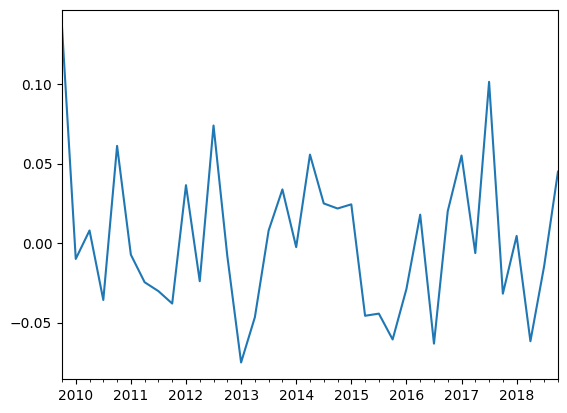

In [121]:
diff2.plot()

<Axes: ylabel='Density'>

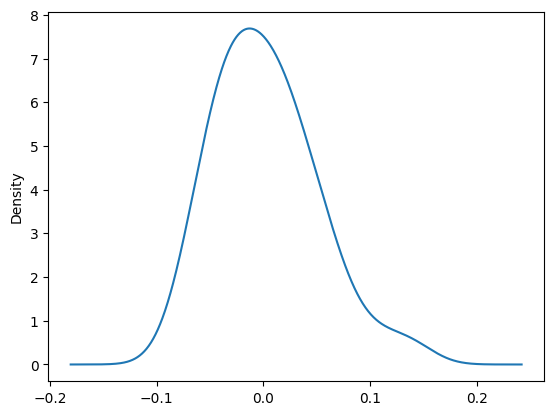

In [122]:
diff2.plot(kind='kde')

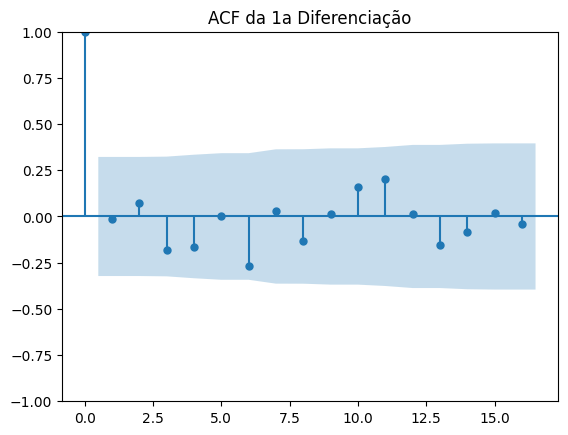

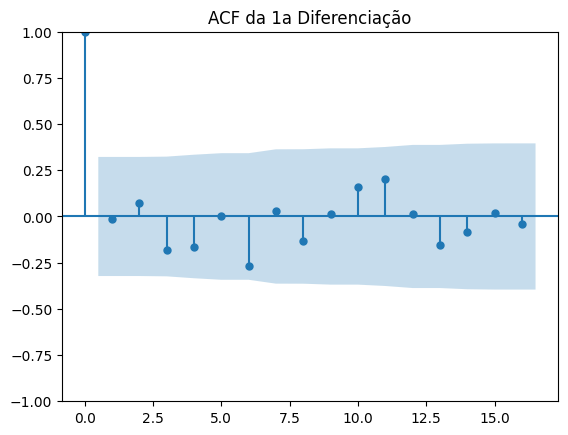

In [123]:
plot_acf(diff2, title='ACF da 1a Diferenciação')

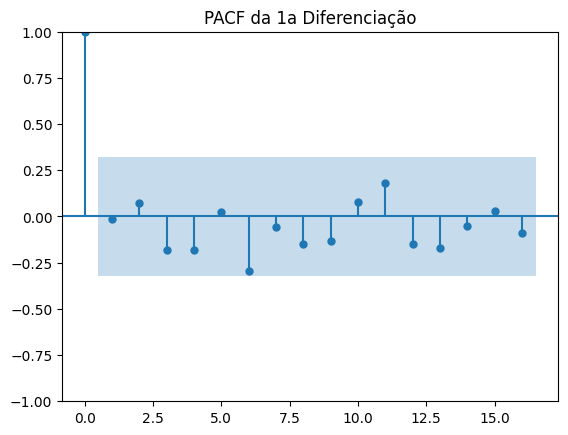

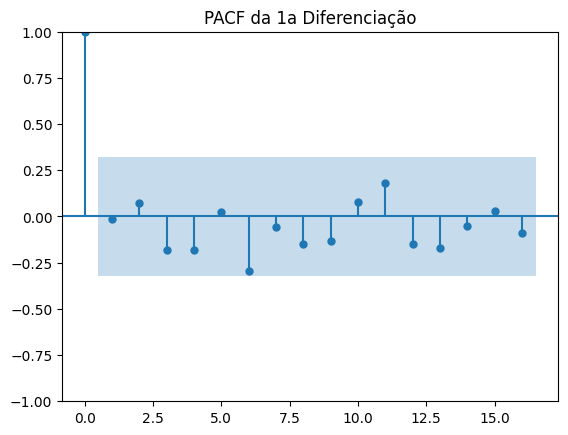

In [124]:
plot_pacf(diff2, title='PACF da 1a Diferenciação')

In [125]:
adf_test(diff2)

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.678896e+00
p-value                 4.393170e-09
# lags used             0.000000e+00
# observations          3.600000e+01
critical value (1%)    -3.626652e+00
critical value (5%)    -2.945951e+00
critical value (10%)   -2.611671e+00
Reject the null hypothesis
Data has no unit root and is stationary


# Modelo AR

## AR(0)

In [126]:
# @title
ar0_model = AutoReg(train_log['y'], 0, old_names=False)
fitted_ar0_model = ar0_model.fit()
print(fitted_ar0_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   42
Model:                     AutoReg(0)   Log Likelihood                 -31.476
Method:               Conditional MLE   S.D. of innovations              0.512
Date:                Fri, 28 Mar 2025   AIC                             66.953
Time:                        15:22:40   BIC                             70.428
Sample:                    09-30-2008   HQIC                            68.227
                         - 12-31-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3585      0.079    169.100      0.000      13.204      13.513


Bons modelos são obtidos minimizando o AIC ou BIC.

<Axes: >

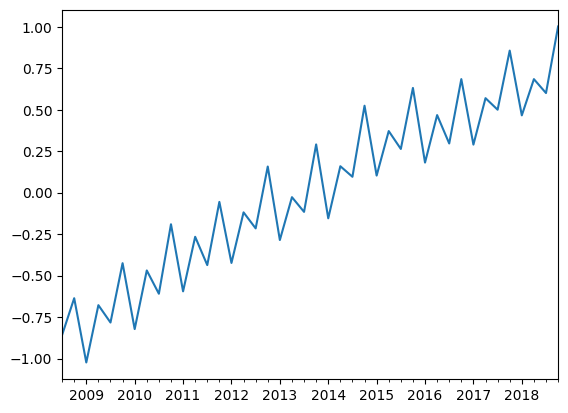

In [127]:
# @title
ar0_resid = fitted_ar0_model.resid
ar0_resid.plot()

<Axes: ylabel='Density'>

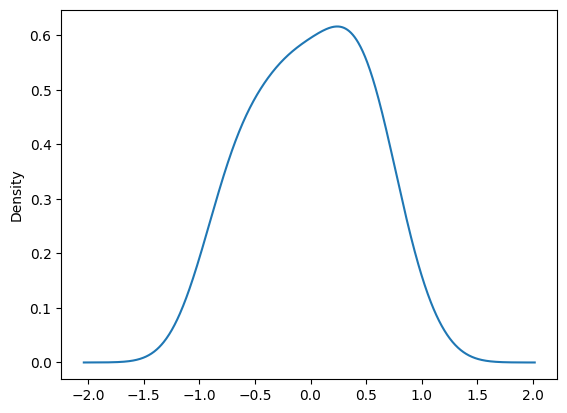

In [128]:
# @title
# density plot of residuals
ar0_resid.plot(kind='kde')

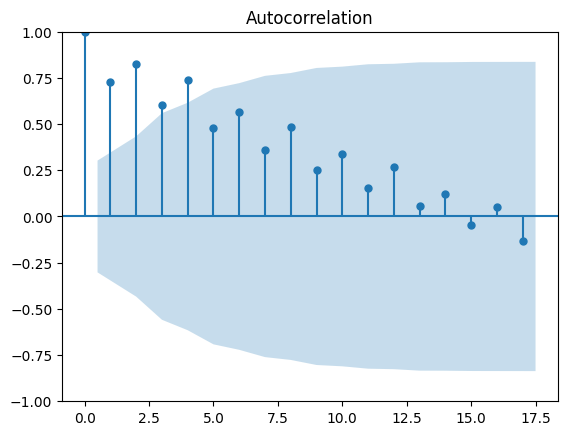

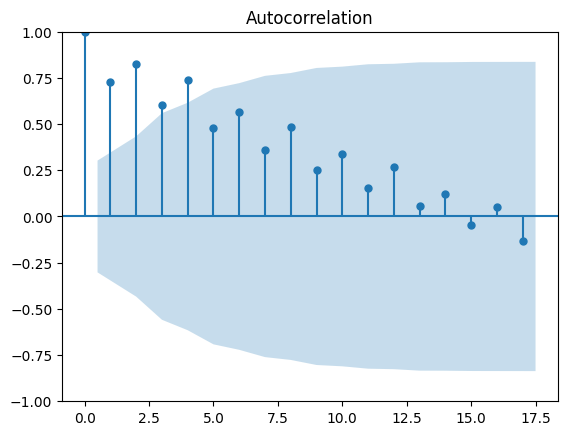

In [129]:
# @title
plot_acf(ar0_resid)

In [130]:
# @title
adf_test(ar0_resid)

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.836832
p-value                  0.362335
# lags used              9.000000
# observations          32.000000
critical value (1%)     -3.653520
critical value (5%)     -2.957219
critical value (10%)    -2.617588
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [131]:
# @title
# This is the general format for obtaining predictions
start=len(train_log)
end=len(train_log)+h-1
ar0_predictions = np.exp(fitted_ar0_model.predict(start=start, end=end, dynamic=False).rename(f'AR(0) Predictions'))

<Axes: >

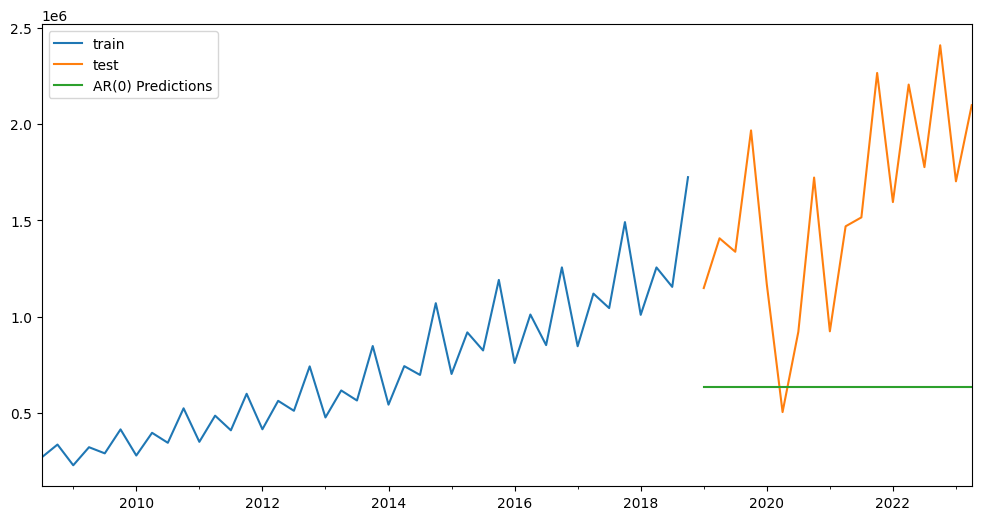

In [132]:
# @title
train['y'].plot(legend=True, label='train')
test['y'].plot(legend=True, label='test')
ar0_predictions.plot(legend=True,figsize=(12,6))

## AR(1)

In [133]:
# @title
ar1_model = AutoReg(train_log['y'], 1, old_names=False)
fitted_ar1_model = ar1_model.fit()
print(fitted_ar1_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   42
Model:                     AutoReg(1)   Log Likelihood                  -9.451
Method:               Conditional MLE   S.D. of innovations              0.305
Date:                Fri, 28 Mar 2025   AIC                             24.901
Time:                        15:22:43   BIC                             30.042
Sample:                    12-31-2008   HQIC                            26.773
                         - 12-31-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6619      1.287      2.068      0.039       0.140       5.184
y.L1           0.8038      0.096      8.334      0.000       0.615       0.993
                                    Roots           

Bons modelos são obtidos minimizando o AIC ou BIC.

<Axes: >

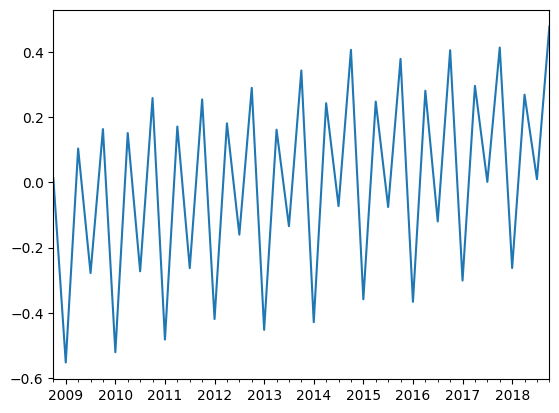

In [134]:
# @title
ar1_resid = fitted_ar1_model.resid
ar1_resid.plot()

<Axes: ylabel='Density'>

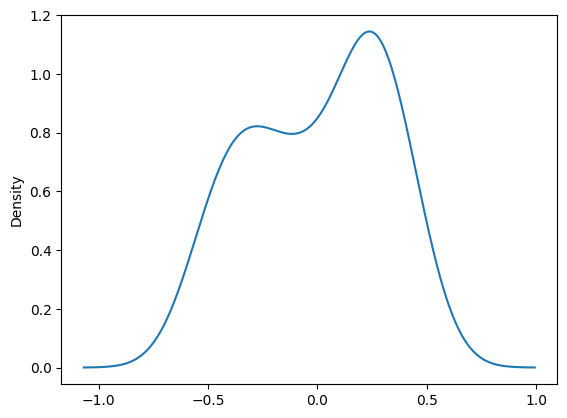

In [135]:
# @title
# density plot of residuals
ar1_resid.plot(kind='kde')

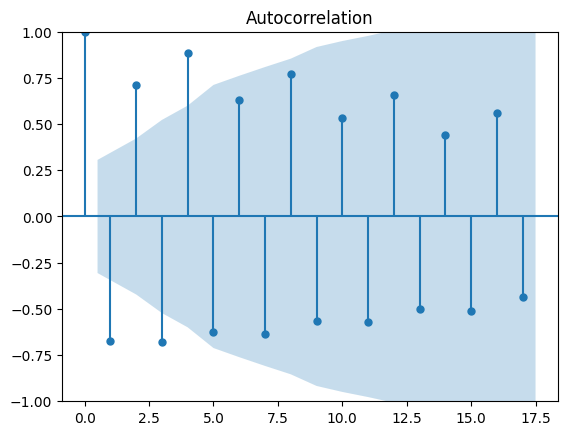

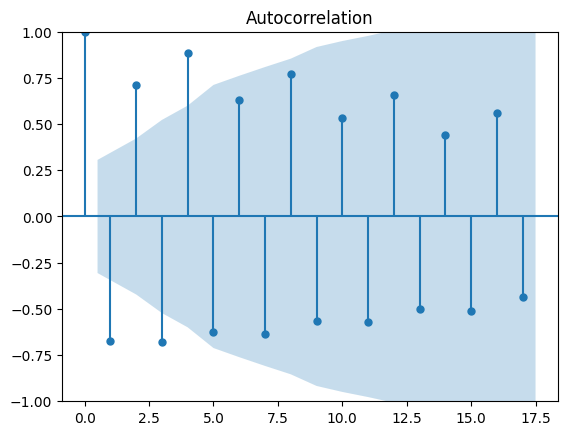

In [136]:
# @title
plot_acf(ar1_resid)

In [137]:
# @title
adf_test(ar1_resid)

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.645638
p-value                  0.459316
# lags used              3.000000
# observations          37.000000
critical value (1%)     -3.620918
critical value (5%)     -2.943539
critical value (10%)    -2.610400
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [138]:
# @title
# This is the general format for obtaining predictions
start=len(train_log)
end=len(train_log)+h-1
ar1_predictions = np.exp(fitted_ar1_model.predict(start=start, end=end, dynamic=False).rename(f'AR(1) Predictions'))

<Axes: >

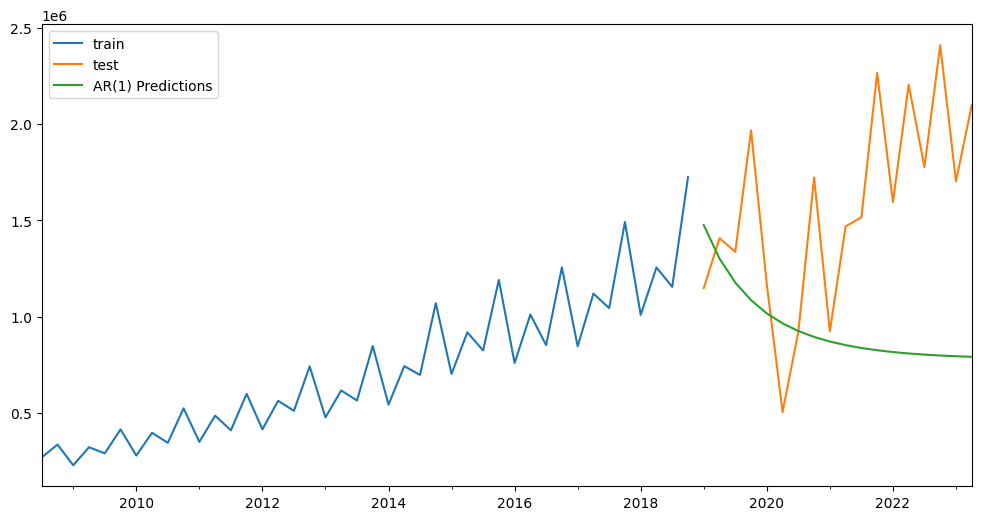

In [139]:
# @title
train['y'].plot(legend=True, label='train')
test['y'].plot(legend=True, label='test')
ar1_predictions.plot(legend=True,figsize=(12,6))

## AR(2)

In [140]:
# @title
ar2_model = AutoReg(train_log['y'], 2, old_names=False)
fitted_ar2_model = ar2_model.fit()
print(fitted_ar2_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   42
Model:                     AutoReg(2)   Log Likelihood                  15.976
Method:               Conditional MLE   S.D. of innovations              0.162
Date:                Fri, 28 Mar 2025   AIC                            -23.951
Time:                        15:22:45   BIC                            -17.196
Sample:                    03-31-2009   HQIC                           -21.509
                         - 12-31-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3423      0.747      0.458      0.647      -1.122       1.807
y.L1           0.1151      0.086      1.339      0.181      -0.053       0.284
y.L2           0.8647      0.085     10.223      0.0

Bons modelos são obtidos minimizando o AIC ou BIC.

<Axes: >

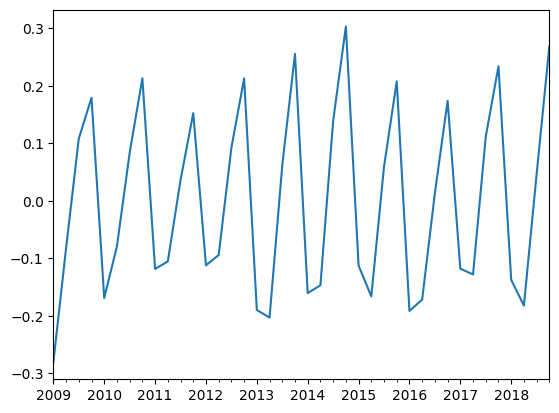

In [141]:
# @title
ar2_resid = fitted_ar2_model.resid
ar2_resid.plot()

<Axes: ylabel='Density'>

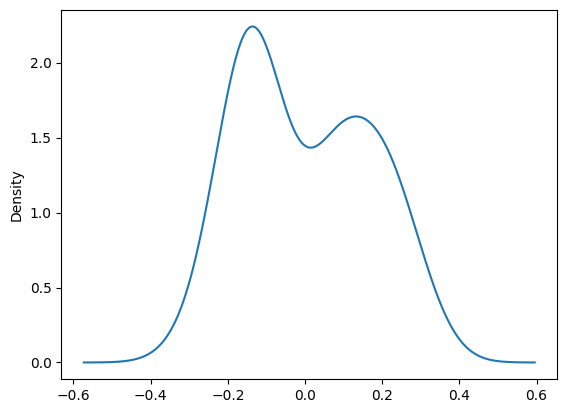

In [142]:
# @title
# density plot of residuals
ar2_resid.plot(kind='kde')

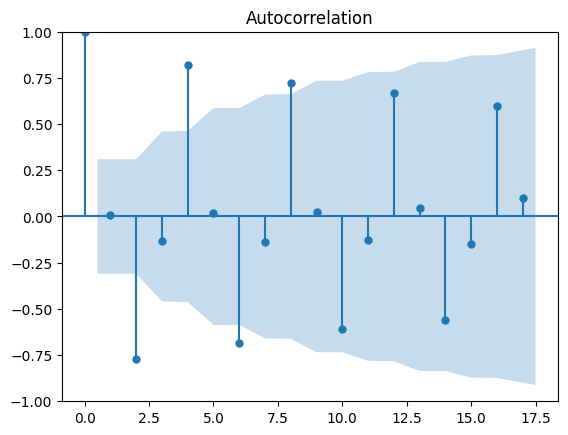

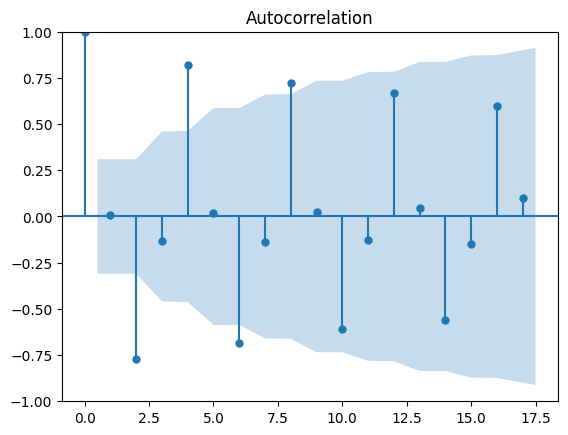

In [143]:
# @title
plot_acf(ar2_resid)

In [144]:
# @title
adf_test(ar2_resid)

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.009387
p-value                  0.001362
# lags used              4.000000
# observations          35.000000
critical value (1%)     -3.632743
critical value (5%)     -2.948510
critical value (10%)    -2.613017
Reject the null hypothesis
Data has no unit root and is stationary


In [145]:
# @title
# This is the general format for obtaining predictions
start=len(train_log)
end=len(train_log)+h-1
ar2_predictions = np.exp(fitted_ar2_model.predict(start=start, end=end, dynamic=False).rename(f'AR(2) Predictions'))

<Axes: >

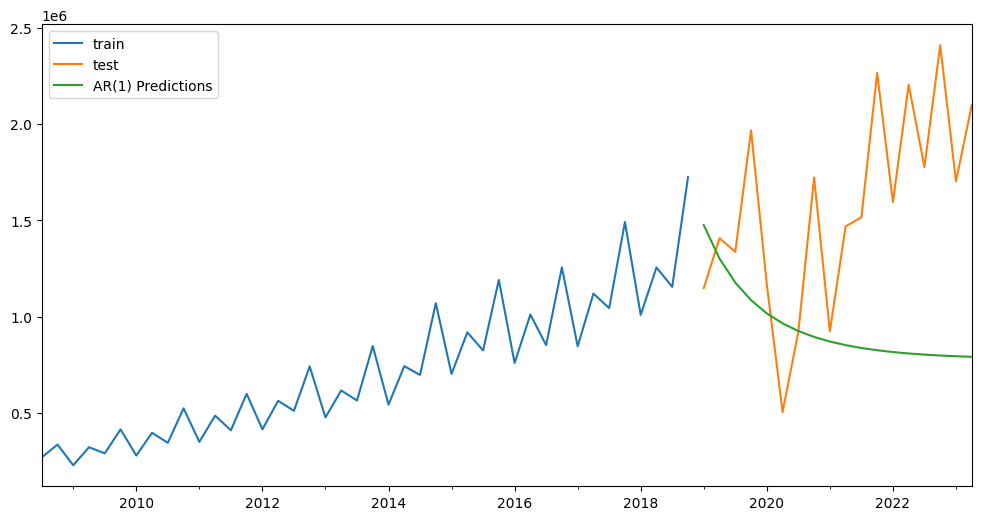

In [146]:
# @title
train['y'].plot(legend=True, label='train')
test['y'].plot(legend=True, label='test')
ar1_predictions.plot(legend=True,figsize=(12,6))

# Comparação

Avaliação de modelos autorregressivos (AR) com diferentes ordens: AR(0), AR(1), AR(2)

Métricas analisadas:
- MSE (Mean Squared Error): erro quadrático médio, penaliza grandes erros. Menor é melhor.
- RMSE (Root MSE): raiz do MSE, na mesma escala da variável original. Menor é melhor.
- MAE (Mean Absolute Error): erro absoluto médio. Menor é melhor.
- R² (Coef. de determinação): mede a proporção da variabilidade explicada pelo modelo.
      - Valor próximo de 1: bom ajuste
      - Valor 0: modelo não explica nada além da média
      - Valor negativo: pior que uma média constante
- MAPE (Erro percentual absoluto médio): pode ser enganoso com valores pequenos. Menor é melhor.
- SMAPE (MAPE simétrico): melhor que MAPE para séries com valores pequenos. Menor é melhor.


In [147]:
# @title
def metrics(test, predictions):
  # Cálculo das métricas de avaliação
  mse = mean_squared_error(test['y'], predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test['y'], predictions)
  r2 = r2_score(test['y'], predictions)

  # Calcular MAPE (Mean Absolute Percentage Error)
  mape = np.mean(np.abs((test['y'] - predictions) / test['y'])) * 100

  # Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
  smape = np.mean(2 * np.abs(test['y'] - predictions) /
                (np.abs(test['y']) + np.abs(predictions))) * 100

  # Exibir as métricas
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R²: {r2}")
  print(f"MAPE: {mape}")
  print(f"SMAPE: {smape}")

print('AR(0) predictions')
metrics( test, ar0_predictions)

print('\nAR(1) predictions')
metrics( test, ar1_predictions)

print('\nAR(2) predictions')
metrics( test, ar2_predictions)

AR(0) predictions
MSE: 1115169329398.0735
RMSE: 1056015.7808470826
MAE: 943897.9435543753
R²: -3.440304640940899
MAPE: 55.942100472438085
SMAPE: 79.89861029879681

AR(1) predictions
MSE: 744287013760.354
RMSE: 862720.7043767722
MAE: 704642.6064621023
R²: -1.9635509104038773
MAPE: 41.745206767418644
SMAPE: 52.793326353448954

AR(2) predictions
MSE: 260110359553.89563
RMSE: 510010.15632425953
MAE: 396087.22166115115
R²: -0.03568956411971769
MAPE: 39.248203494131964
SMAPE: 26.233767166571297
